# Image viewer

This notebook is for inspecting timelapse microscopy data, with associated sinhgle-cell labels and tracks, showing the infection of human macrophages with Mycobacterium Tuberculosis (Mtb), acquired on an Opera Phenix confocal microscope. 

In [1]:
import napari
import os, glob
from macrohet import dataio, tile, visualise, notify
import numpy as np
from macrohet import visualise
import os
import re
import numpy as np
import cv2
import btrack
import zarr

### Load experiment of choice

The Opera Phenix is a high-throughput confocal microscope that acquires very large 5-dimensional (TCZXY) images over several fields of view in any one experiment. Therefore, a lazy-loading approach is chosen to mosaic, view and annotate these images. This approach depends upon Dask and DaskFusion. The first step is to load the main metadata file (typically called `Index.idx.xml` and located in the main `Images` directory) that contains the image filenames and associated TCXZY information used to organise the images.

In [2]:
%%time
expt_ID = 'PS0000'

base_dir = f'/mnt/SYNO/macrohet_syno/{expt_ID}/'
# base_dir = f'/mnt/DATA/macrohet/{expt_ID}/'

metadata_fn = glob.glob(os.path.join(base_dir, 'acquisition/Images/Index*xml'))[0]
metadata = dataio.read_harmony_metadata(metadata_fn)  
metadata

Reading metadata XML file...


0it [00:00, ?it/s]

Extracting metadata complete!
CPU times: user 10 s, sys: 691 ms, total: 10.7 s
Wall time: 11.6 s


,id,State,URL,Row,Col,FieldID,PlaneID,TimepointID,ChannelID,FlimID,...,PositionZ,AbsPositionZ,MeasurementTimeOffset,AbsTime,MainExcitationWavelength,MainEmissionWavelength,ObjectiveMagnification,ObjectiveNA,ExposureTime,OrientationMatrix
0,0303K1F1P1R1,Ok,r03c03f01p01-ch1sk1fk1fl1.tiff,3,3,1,1,0,1,1,...,0,0.135583505,0,2021-04-16T19:09:33.84+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
1,0303K1F1P1R2,Ok,r03c03f01p01-ch2sk1fk1fl1.tiff,3,3,1,1,0,2,1,...,0,0.135583505,0,2021-04-16T19:09:33.84+01:00,640,706,40,1.1,0.2,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
2,0303K1F1P2R1,Ok,r03c03f01p02-ch1sk1fk1fl1.tiff,3,3,1,2,0,1,1,...,2E-06,0.135585502,0,2021-04-16T19:09:34.12+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
3,0303K1F1P2R2,Ok,r03c03f01p02-ch2sk1fk1fl1.tiff,3,3,1,2,0,2,1,...,2E-06,0.135585502,0,2021-04-16T19:09:34.12+01:00,640,706,40,1.1,0.2,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
4,0303K1F1P3R1,Ok,r03c03f01p03-ch1sk1fk1fl1.tiff,3,3,1,3,0,1,1,...,4E-06,0.135587499,0,2021-04-16T19:09:34.4+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113395,0609K75F9P1R2,Ok,r06c09f09p01-ch2sk75fk1fl1.tiff,6,9,9,1,74,2,1,...,0,0.135533601,266399.61,2021-04-19T21:14:19.477+01:00,640,706,40,1.1,0.2,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
113396,0609K75F9P2R1,Ok,r06c09f09p02-ch1sk75fk1fl1.tiff,6,9,9,2,74,1,1,...,2E-06,0.135535598,266399.61,2021-04-19T21:14:19.757+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
113397,0609K75F9P2R2,Ok,r06c09f09p02-ch2sk75fk1fl1.tiff,6,9,9,2,74,2,1,...,2E-06,0.135535598,266399.61,2021-04-19T21:14:19.757+01:00,640,706,40,1.1,0.2,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
113398,0609K75F9P3R1,Ok,r06c09f09p03-ch1sk75fk1fl1.tiff,6,9,9,3,74,1,1,...,4E-06,0.135537595,266399.61,2021-04-19T21:14:20.037+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."


### View assay layout and mask information (optional)

The Opera Phenix acquires many time lapse series from a range of positions. The first step is to inspect the image metadata, presented in the form of an `Assaylayout/experiment_ID.xml` file, to show which positions correspond to which experimental assays.

In [3]:
metadata_path = glob.glob(os.path.join(base_dir, 'acquisition/Assaylayout/*.xml'))[0]
assay_layout = dataio.read_harmony_metadata(metadata_path, assay_layout=True,replicate_number=False)# mask_exist=True,  image_dir = image_dir, image_metadata = metadata)
assay_layout

Reading metadata XML file...
Extracting metadata complete!


Strain Compound Concentration ConcentrationEC
Row Column                                              
3   4         RD1     CTRL             0             EC0
    5          WT     CTRL             0             EC0
    6          WT      PZA            60            EC50
    7          WT      RIF           0.1            EC50
    8          WT      INH          0.04            EC50
    9          WT      BDQ          0.02            EC50
4   4         RD1     CTRL             0             EC0
    5          WT     CTRL             0             EC0
    6          WT      PZA            60            EC50
    7          WT      RIF           0.1            EC50
    8          WT      INH          0.04            EC50
    9          WT      BDQ          0.02            EC50
5   4         RD1     CTRL             0             EC0
    5          WT     CTRL             0             EC0
    6          WT      PZA           400            EC99
    7          WT      RIF             2            EC99
    8          WT      INH             2            EC99
    9          WT      BDQ           2.5            EC99
6   4         RD1     CTRL             0             EC0
    5          WT     CTRL             0             EC0
    6          WT      PZA           400            EC99
    7          WT      RIF             2            EC99
    8          WT      INH             2            EC99
    9          WT      BDQ           2.5            EC99

### Load using Zarr

In [4]:
acq_ID = (3, 4)

In [5]:
image_dir = os.path.join(base_dir, f'acquisition/zarr/{acq_ID}.zarr')
zarr_group = zarr.open(image_dir, mode='r')

In [30]:
images = zarr_group.images[0,:,:,...]
images.shape

(2, 3, 6048, 6048)

In [31]:
images = np.sum(images, axis = 1)

In [8]:
# Create an empty RGB image with shape (height, width, 3)
rgb_image = np.zeros((images.shape[1], images.shape[2], 3), dtype=images.dtype)

# Assign the first channel to the red and blue channels (magenta)
rgb_image[..., 0] = images[0]  # Red channel
rgb_image[..., 2] = images[0]  # Blue channel

# Assign the second channel to the green channel
rgb_image[..., 1] = images[1]  # Green channel


In [9]:
import matplotlib.pyplot as plt

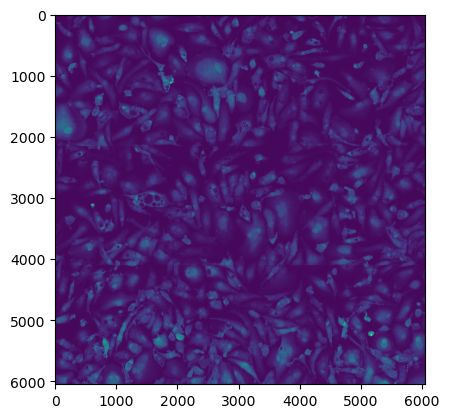

In [10]:
plt.imshow(images[0])

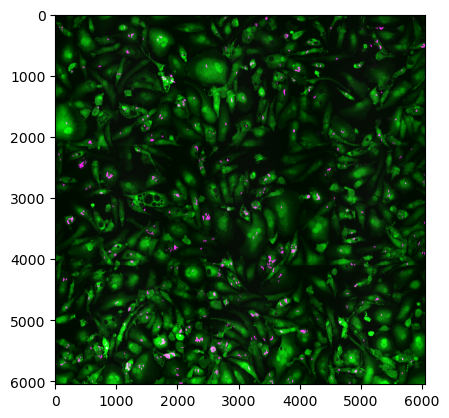

In [11]:
# Create an empty RGB image with shape (height, width, 3)
rgb_image = np.zeros((images.shape[1], images.shape[2], 3), dtype=np.float32)

# Normalize the magenta channel (first channel) to the range 480-500
magenta_channel = np.clip(images[1], 350, 1000)
magenta_channel = (magenta_channel - 350) / (1000 - 350)

# Normalize the green channel (second channel) to the range 300-5000
green_channel = np.clip(images[0], 0, 7000)
green_channel = (green_channel - 0) / (7000 - 0)

# Assign the first channel to the red and blue channels (magenta)
rgb_image[..., 0] = magenta_channel  # Red channel
rgb_image[..., 2] = magenta_channel  # Blue channel

# Assign the second channel to the green channel
rgb_image[..., 1] = green_channel  # Green channel

# Ensure the values are between 0 and 1
rgb_image = np.clip(rgb_image, 0, 1)

# Convert to 8-bit (0-255) and save the image
rgb_image_8bit = (rgb_image * 255).astype(np.uint8)
plt.imshow(rgb_image_8bit)
# # Save the image
plt.imsave('/mnt/SYNO/macrohet_syno/poster/t-1_normal.png', rgb_image_8bit)

In [ ]:
%%time
images = np.sum(images, axis = 2)

In [15]:
viewer = napari.Viewer(title = f'{expt_ID, acq_ID}, full image stack')

viewer.add_image(images,
                 channel_axis = 0, 
                 # # scale = napari_scale, 
                 contrast_limits=[[350, 1000],[0, 7000]]
                )

[<Image layer 'Image' at 0x7f2a2ae06d90>,
 <Image layer 'Image [1]' at 0x7f2bb70affd0>]

In [ ]:
with btrack.io.HDF5FileHandler(os.path.join(f'/mnt/SYNO/macrohet_syno/{expt_ID}/labels/cpv3/{acq_ID}.h5'), 
                                           'r', 
                                           obj_type='obj_type_1'
                                           ) as reader:
                segmentation = reader.segmentation
                tracks = reader.tracks

In [ ]:
'/mnt/SYNO/macrohet_syno/PS0000/labels/macrohet_seg_model/

In [14]:
with btrack.io.HDF5FileHandler(os.path.join(f'/mnt/SYNO/macrohet_syno/{expt_ID}/labels/macrohet_seg_model/{acq_ID}.h5'), 
                                           'r', 
                                           obj_type='obj_type_1'
                                           ) as reader:
                segmentation = reader.segmentation
                tracks = reader.tracks

[INFO][2024/06/10 11:44:45 AM] Opening HDF file: /mnt/SYNO/macrohet_syno/PS0000/labels/macrohet_seg_model/(3, 4).h5...
INFO:btrack.io.hdf:Opening HDF file: /mnt/SYNO/macrohet_syno/PS0000/labels/macrohet_seg_model/(3, 4).h5...
[INFO][2024/06/10 11:44:55 AM] Loading segmentation (75, 6048, 6048)
INFO:btrack.io.hdf:Loading segmentation (75, 6048, 6048)
[INFO][2024/06/10 11:44:55 AM] Loading tracks/obj_type_1
INFO:btrack.io.hdf:Loading tracks/obj_type_1
[INFO][2024/06/10 11:44:55 AM] Loading LBEP/obj_type_1
INFO:btrack.io.hdf:Loading LBEP/obj_type_1
[INFO][2024/06/10 11:44:55 AM] Loading objects/obj_type_1 (39878, 5) (39878 filtered: None)
INFO:btrack.io.hdf:Loading objects/obj_type_1 (39878, 5) (39878 filtered: None)
[INFO][2024/06/10 11:44:56 AM] Closing HDF file: /mnt/SYNO/macrohet_syno/PS0000/labels/macrohet_seg_model/(3, 4).h5
INFO:btrack.io.hdf:Closing HDF file: /mnt/SYNO/macrohet_syno/PS0000/labels/macrohet_seg_model/(3, 4).h5


In [26]:
recoloured_seg = btrack.utils.update_segmentation(segmentation, filtered_tracks, scale = (5.04, 5.04))

In [25]:
help(btrack.utils.update_segmentation)

Help on function update_segmentation in module btrack.utils:

update_segmentation(segmentation: 'npt.NDArray', tracks: 'list[btypes.Tracklet]', *, scale: 'Optional[tuple(float)]' = None, color_by: 'str' = 'ID') -> 'npt.NDArray'
    Map tracks back into a masked array.
    
    Parameters
    ----------
    segmentation : npt.NDArray
        Array containing a timeseries of single cell masks. Dimensions should be
        ordered T(Z)YX. Assumes that this is not binary and each object has a unique ID.
    tracks : list[btypes.Tracklet]
        A list of :py:class:`btrack.btypes.Tracklet` objects from BayesianTracker.
    scale : tuple, optional
        A scale for each spatial dimension of the input tracks. Defaults
        to one for all axes, and allows scaling for anisotropic imaging data.
        Dimensions should be ordered XY(Z).
    color_by : str, default = "ID"
        A value to recolor the segmentation by.
    
    Returns
    -------
    relabeled : npt.NDArray
        Array 

In [16]:
viewer.add_labels(segmentation)

<Labels layer 'segmentation' at 0x7f2bb7882d60>

In [12]:
filtered_tracks = [track for track in tracks if len(track) > 70]

In [19]:
napari_tracks, _, _ = btrack.utils.tracks_to_napari(tracks, ndim = 2)

In [20]:
viewer.add_tracks(napari_tracks, scale=(5.04, 5.04), name = 'filtered')

<Tracks layer 'filtered' at 0x7f2a61ae6460>

In [27]:
viewer.add_labels(np.zeros_like(segmentation[0]))

<Labels layer 'Labels' at 0x7fc05c10f580>

In [33]:
viewer.add_image(images,
                 channel_axis = 0, 
                 colormap=['green', 'magenta'],
                 contrast_limits=[[0, 7000], [350, 1000]], blending = 'additive', name = 't0',
                )

[<Image layer 't0' at 0x7f2a24edfeb0>,
 <Image layer 't0 [1]' at 0x7f2bb72f0970>]

In [ ]:
viewer.add_labels(segmentation)

In [36]:
viewer.screenshot("/mnt/SYNO/macrohet_syno/poster/t-1_masks_tracks.png", size =(1200, 1200))

array([[[  0,   0,   0, 255],
        [  0,   0,   0, 255],
        [  0,   0,   0, 255],
        ...,
        [  0,   0,   0, 255],
        [  0,   0,   0, 255],
        [  0,   0,   0, 255]],

       [[  0,   0,   0, 255],
        [  0,   0,   0, 255],
        [  0,   0,   0, 255],
        ...,
        [  0,   0,   0, 255],
        [  0,   0,   0, 255],
        [  0,   0,   0, 255]],

       [[  0,   0,   0, 255],
        [  0,   0,   0, 255],
        [  0,   0,   0, 255],
        ...,
        [  0,   0,   0, 255],
        [  0,   0,   0, 255],
        [  0,   0,   0, 255]],

       ...,

       [[  0,   0,   0, 255],
        [  0,   0,   0, 255],
        [  0,   0,   0, 255],
        ...,
        [  0,   0,   0, 255],
        [  0,   0,   0, 255],
        [  0,   0,   0, 255]],

       [[  0,   0,   0, 255],
        [  0,   0,   0, 255],
        [  0,   0,   0, 255],
        ...,
        [  0,   0,   0, 255],
        [  0,   0,   0, 255],
        [  0,   0,   0, 255]],

       [[  0